In [1]:
# STEP 1: Setup Kaggle API

# Upload your kaggle.json (from Kaggle > Account > API > Create New API Token)
from google.colab import files
files.upload()  # choose kaggle.json

# Make a hidden .kaggle directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Give permissions
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
# STEP 2: Download Dataset

!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip -q brain-mri-images-for-brain-tumor-detection.zip -d dataset

# The dataset will now be in "dataset/yes" and "dataset/no"


Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 969MB/s]


In [3]:
# STEP 3: Import Libraries

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
# STEP 4: Load & Preprocess Data

IMG_SIZE = 150
YES_DIR = "dataset/yes"
NO_DIR = "dataset/no"

def load_data(dir_yes, dir_no, img_size):
    data, labels = [], []
    for class_label, dir_path in [(1, dir_yes), (0, dir_no)]:
        for img_name in os.listdir(dir_path):
            img_path = os.path.join(dir_path, img_name)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (img_size, img_size))
                data.append(img)
                labels.append(class_label)
            except:
                continue
    return np.array(data) / 255.0, np.array(labels)

print("Loading images...")
X, y = load_data(YES_DIR, NO_DIR, IMG_SIZE)
print(f"Dataset size: {len(X)} images")


Loading images...
Dataset size: 253 images


In [5]:
# STEP 5: Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [6]:
# STEP 6: Data Augmentation

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

In [7]:
# STEP 7: Build CNN Model

def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model((IMG_SIZE, IMG_SIZE, 3))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,564,609 (36.49 MB)

 Trainable params: 9,564,161 (36.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
# STEP 8: Train Model

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_brain_tumor_model.h5", monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5890 - loss: 7.7896

7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5934 - loss: 7.8540 - val_accuracy: 0.6471 - val_loss: 0.6073
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6617 - loss: 4.6387

7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6600 - loss: 4.6900 - val_accuracy: 0.7843 - val_loss: 0.6595
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6312 - loss: 3.5404 - val_accuracy: 0.6667 - val_loss: 0.7705
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7211 - loss: 3.0823 - val_accuracy: 0.6275 - val_loss: 1.2540
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7209 - loss: 1.9348 - val_accuracy: 0.6275 - val_loss: 1.3302
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6575 - loss: 1.0747 - val_accuracy: 0.6078 - val_loss: 1.9913


In [9]:
# STEP 9: Evaluate
# ============================

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.60      0.57        20
           1       0.72      0.68      0.70        31

    accuracy                           0.65        51
   macro avg       0.63      0.64      0.64        51
weighted avg       0.65      0.65      0.65        51

Confusion Matrix:
 [[12  8]
 [10 21]]


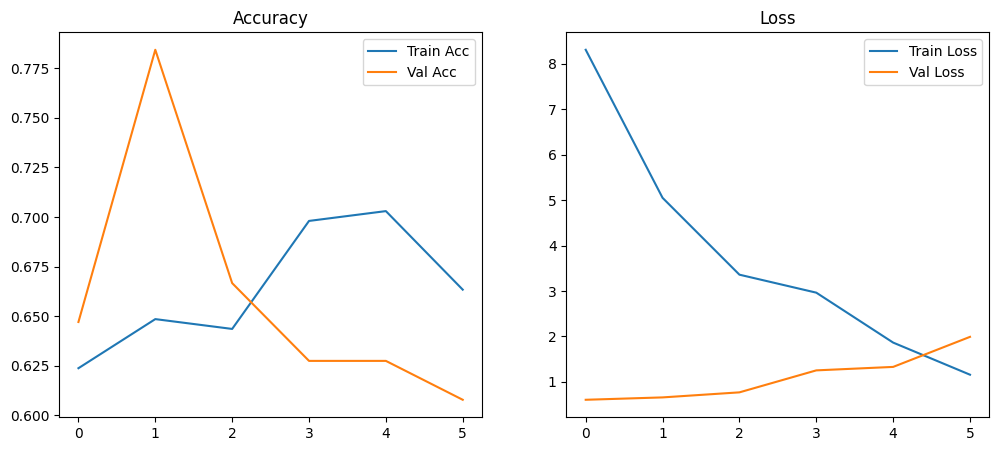

In [10]:
# STEP 10: Plot Results

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()

Confusion Matrix:
 [[12  8]
 [10 21]]


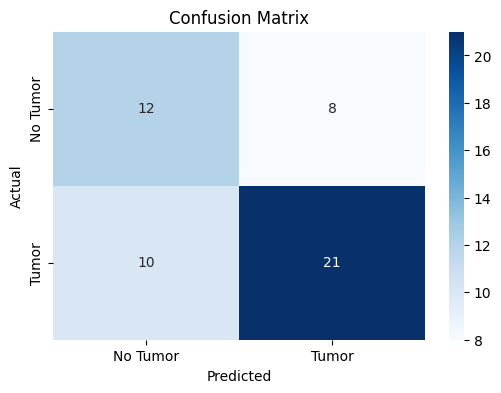

In [13]:
#STEP 11: Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

AUC Score: 0.7548387096774194


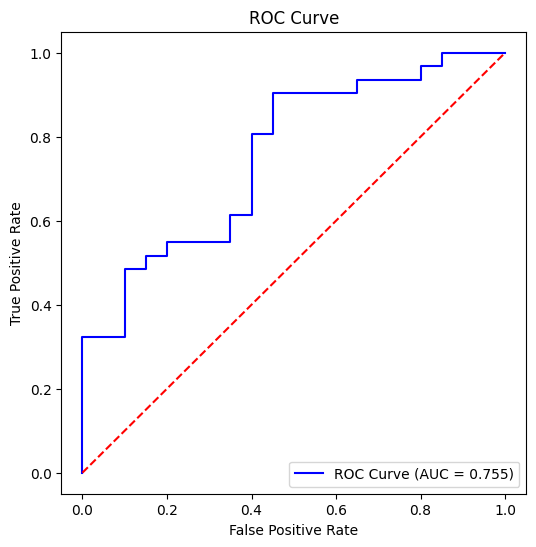

In [14]:
# STEP 12: ROC Curve & AUC

from sklearn.metrics import roc_curve, roc_auc_score

# y_pred_prob already contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

print("AUC Score:", auc_score)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

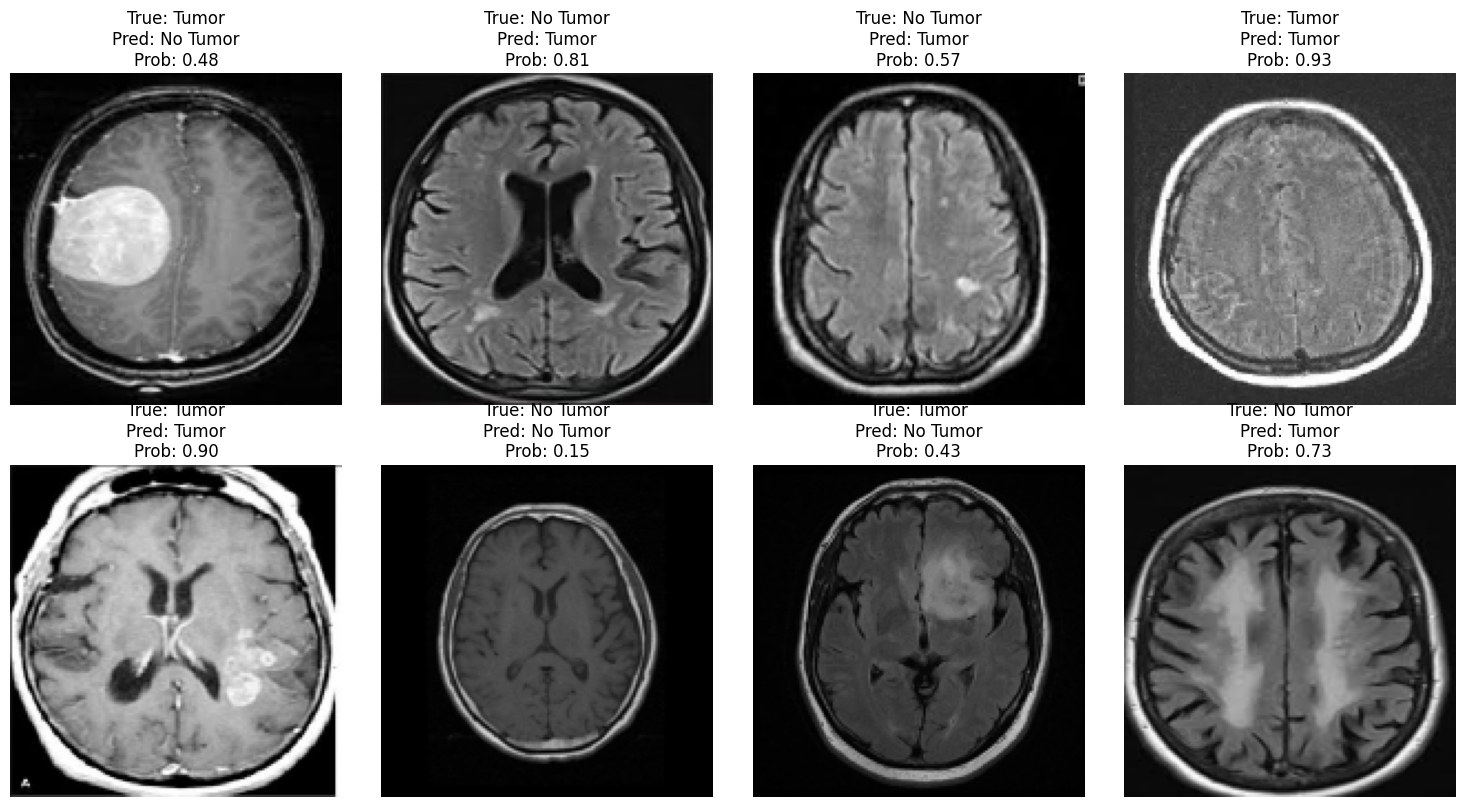

In [19]:
# STEP 12: Visualize Predictions on Sample Images

import random

# pick random test images
num_samples = 8
indices = random.sample(range(len(X_test)), num_samples)

plt.figure(figsize=(15, 12))

for i, idx in enumerate(indices):
    img = X_test[idx]
    true_label = "Tumor" if y_test[idx] == 1 else "No Tumor"
    pred_prob = y_pred_prob[idx][0]
    pred_label = "Tumor" if pred_prob > 0.5 else "No Tumor"

    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}\nProb: {pred_prob:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Saving 14 no.jpg to 14 no.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


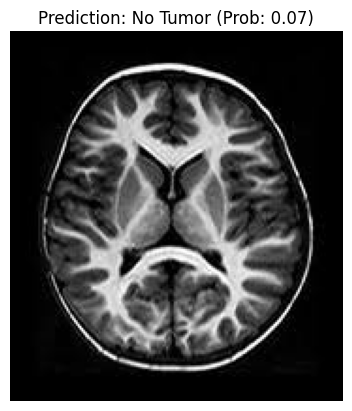

In [23]:
# STEP 13: Upload & Predict on a New Image

from google.colab import files
from tensorflow.keras.preprocessing import image

# Upload image
uploaded = files.upload()

for fn in uploaded.keys():
    img_path = fn
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

    prediction = model.predict(img_array)[0][0]

    if prediction > 0.5:
        label = "Tumor"
    else:
        label = "No Tumor"

    plt.imshow(image.load_img(img_path))
    plt.title(f"Prediction: {label} (Prob: {prediction:.2f})")
    plt.axis("off")
    plt.show()
